In [1]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
#pd.options.display.max_columns = 8
plt.style.use('dark_background')
import subprocess
%config IPCompleter.use_jedi = False

In [2]:
!cat /home/xar/.kaggle/kaggle.json

{"username":"maxmattson","key":"d6fd54bc427921f2a2b17374d2321dc4"}

In [3]:
creds = '{"username":"maxmattson","key":"d6fd54bc427921f2a2b17374d2321dc4"}'

In [4]:
credPath = Path('/home/xar/.kaggle/kaggle.json').expanduser()
credPath

Path('/home/xar/.kaggle/kaggle.json')

In [5]:
path = URLs.path('bikeshare')
path = Path('/media/xar/barracuda1/fast.ai/data/bikeshare')
path

Path('/media/xar/barracuda1/fast.ai/data/bikeshare')

In [6]:
if not path.exists():
    path.mkdir(parents=True)
    api.competition_download_cli('bike-sharing-demand', path=path)
    file_extract(path/'bike-sharing-demand.zip')
    
path.ls(file_type='text')

(#3) [Path('/media/xar/barracuda1/fast.ai/data/bikeshare/test.csv'),Path('/media/xar/barracuda1/fast.ai/data/bikeshare/sampleSubmission.csv'),Path('/media/xar/barracuda1/fast.ai/data/bikeshare/train.csv')]

### Look at the data

In [7]:
df = pd.read_csv(path/'train.csv', low_memory=False)

In [8]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

#### Handle ordinal columns (non-numeric)

In [9]:
for col in df.columns:
    print(col,':', df[col].unique())

datetime : ['2011-01-01 00:00:00' '2011-01-01 01:00:00' '2011-01-01 02:00:00' ... '2012-12-19 21:00:00' '2012-12-19 22:00:00' '2012-12-19 23:00:00']
season : [1 2 3 4]
holiday : [0 1]
workingday : [0 1]
weather : [1 2 3 4]
temp : [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3  10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7
 30.34 31.16 29.52 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36 41.  ]
atemp : [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575 15.91   3.03   3.79   4.545 15.15  18.18  25.    26.515
 27.275 29.545 23.485 25.76  31.06  30.305 24.24  18.94  31.82  32.575 33.335 28.79  34.85  35.605 37.12  40.15  41.665 40.91  39.395 34.09  28.03  36.365 37.88  42.425 43.94  38.635  1.515  0.76
  2.275 43.18  44.695 45.455]
humidity : [ 81  80  75  86  76  77  72  82

In [10]:
depVar = 'count'

The metric that they want us to use is RMSLE (root mean square log error) to do this we can convert the dependent variable 'counts' into `log(count)` and then use RMSE as our metric which is already built in.

In [11]:
df[depVar] = np.log(df[depVar])

### Handle dates

In [12]:
df = add_datepart(df, 'datetime')

In [13]:
dfTest = pd.read_csv(path/'test.csv', low_memory=False)
dfTest = add_datepart(dfTest, 'datetime')

In [14]:
' '.join(o for o in df.columns if o.startswith('datetime'))

'datetimeYear datetimeMonth datetimeWeek datetimeDay datetimeDayofweek datetimeDayofyear datetimeIs_month_end datetimeIs_month_start datetimeIs_quarter_end datetimeIs_quarter_start datetimeIs_year_end datetimeIs_year_start datetimeElapsed'

### Using TabularPandas and TabularProc

In [15]:
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count',
       'datetimeYear', 'datetimeMonth', 'datetimeWeek', 'datetimeDay',
       'datetimeDayofweek', 'datetimeDayofyear', 'datetimeIs_month_end',
       'datetimeIs_month_start', 'datetimeIs_quarter_end',
       'datetimeIs_quarter_start', 'datetimeIs_year_end',
       'datetimeIs_year_start', 'datetimeElapsed'],
      dtype='object')

In [16]:
for col in df.columns:
    print(col, ':', df[col].unique())

season : [1 2 3 4]
holiday : [0 1]
workingday : [0 1]
weather : [1 2 3 4]
temp : [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3  10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7
 30.34 31.16 29.52 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36 41.  ]
atemp : [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575 15.91   3.03   3.79   4.545 15.15  18.18  25.    26.515
 27.275 29.545 23.485 25.76  31.06  30.305 24.24  18.94  31.82  32.575 33.335 28.79  34.85  35.605 37.12  40.15  41.665 40.91  39.395 34.09  28.03  36.365 37.88  42.425 43.94  38.635  1.515  0.76
  2.275 43.18  44.695 45.455]
humidity : [ 81  80  75  86  76  77  72  82  88  87  94 100  71  66  57  46  42  39  44  47  50  43  40  35  30  32  64  69  55  59  63  68  74  51  56  52  49  48  37  33  28  38  36  93  29 

In [17]:
procs = [Categorify, FillMissing]

I'm going to try making the validation set the last 2 days of each month in the training set, i.e. 18th--19th of each month.

In [18]:
cond = (df.datetimeDay>=18)
trainIdx = np.where(~cond)[0]
validIdx = np.where( cond)[0]

splits = (list(trainIdx), list(validIdx))

In [19]:
cont,cat = cont_cat_split(df, max_card=18, dep_var=depVar)
cont, cat

(['temp',
  'atemp',
  'humidity',
  'windspeed',
  'casual',
  'registered',
  'datetimeWeek',
  'datetimeDay',
  'datetimeDayofyear',
  'datetimeElapsed'],
 ['season',
  'holiday',
  'workingday',
  'weather',
  'datetimeYear',
  'datetimeMonth',
  'datetimeDayofweek',
  'datetimeIs_month_end',
  'datetimeIs_month_start',
  'datetimeIs_quarter_end',
  'datetimeIs_quarter_start',
  'datetimeIs_year_end',
  'datetimeIs_year_start'])

In [20]:
to = TabularPandas(df, 
                   procs=procs, 
                   cat_names=cat, 
                   cont_names=cont, 
                   y_names=depVar, 
                   splits=splits)

In [21]:
len(to.train), len(to.valid)

(9749, 1137)

In [22]:
to.show(5)

,season,holiday,workingday,weather,datetimeYear,datetimeMonth,datetimeDayofweek,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,temp,atemp,humidity,windspeed,casual,registered,datetimeWeek,datetimeDay,datetimeDayofyear,datetimeElapsed,count
0,1,0,0,1,2011,1,5,False,True,False,True,False,True,9.84,14.395,81,0.0,3,13,52,1,1,1.293840e+09,2.772589
1,1,0,0,1,2011,1,5,False,True,False,True,False,True,9.02,13.635,80,0.0,8,32,52,1,1,1.293844e+09,3.688879
2,1,0,0,1,2011,1,5,False,True,False,True,False,True,9.02,13.635,80,0.0,5,27,52,1,1,1.293847e+09,3.465736
3,1,0,0,1,2011,1,5,False,True,False,True,False,True,9.84,14.395,75,0.0,3,10,52,1,1,1.293851e+09,2.564949
4,1,0,0,1,2011,1,5,False,True,False,True,False,True,9.84,14.395,75,0.0,0,1,52,1,1,1.293854e+09,0.000000


In [23]:
to.items.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeElapsed
0,1,1,1,1,9.84,14.395,81,0.0,3,13,2.772589,1,1,52,1,6,1,1,2,1,2,1,2,1.293840e+09
1,1,1,1,1,9.02,13.635,80,0.0,8,32,3.688879,1,1,52,1,6,1,1,2,1,2,1,2,1.293844e+09
2,1,1,1,1,9.02,13.635,80,0.0,5,27,3.465736,1,1,52,1,6,1,1,2,1,2,1,2,1.293847e+09
3,1,1,1,1,9.84,14.395,75,0.0,3,10,2.564949,1,1,52,1,6,1,1,2,1,2,1,2,1.293851e+09
4,1,1,1,1,9.84,14.395,75,0.0,0,1,0.000000,1,1,52,1,6,1,1,2,1,2,1,2,1.293854e+09


In [24]:
save_pickle(path/'to.pkl',to)

### Creating the Decision Tree

In [25]:
to = load_pickle(path/'to.pkl')

In [26]:
xs,y = to.train.xs, to.train.y
validXs,validY = to.valid.xs, to.valid.y

In [27]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

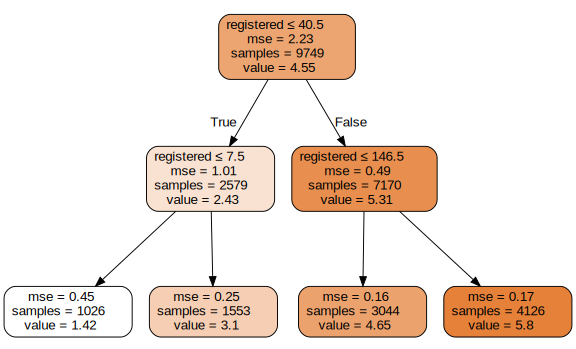

In [28]:
draw_tree(m, xs, size=8, leaves_parallel=True, precision=2)

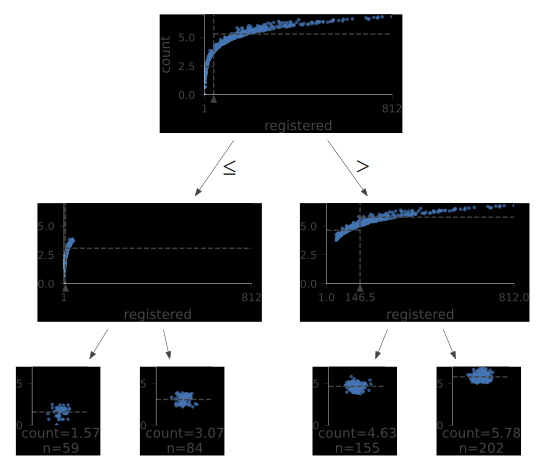

In [29]:
sampIdx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[sampIdx], y.iloc[sampIdx], xs.columns, depVar,
         scale=1.8, label_fontsize=10, orientation='TB', fontname='DejaVu Sans')

Now build bigger tree algorithm, so don't pass in `max_leaf_nodes`,

In [30]:
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

Now we'll create a function for the root mean squared error, `m_rmse`, because the competition was judged using the RMSLE (root mean squared log error) as the metric so since our counts are already the `log(counts)` using RMSE here is doing RMSLE.

In [31]:
def r_mse(pred, y): return round(math.sqrt(((np.log(pred+1)-np.log(y+1))**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [32]:
m_rmse(m, xs, y)

0.0

Check valid to see if model is overfitting, which it obviously is,

In [33]:
m_rmse(m, validXs, validY)

0.013927

So we are overfitting, because we have nearly as many leaf nodes as data points,

In [34]:
m.get_n_leaves(), len(xs)

(5438, 9749)

Change stopping rule to have more data points in each leaf node,

In [35]:
m = DecisionTreeRegressor(min_samples_leaf=30)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, validXs, validY)

(0.022256, 0.032046)

In [36]:
m.get_n_leaves()

241

### Creating a Random Forest

In [37]:
def rf(xs, y, n_estimators=80, max_samples=5_000, max_features=0.5,
       min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1,
                                 n_estimators=n_estimators,
                                 max_samples=max_samples,
                                 max_features=max_features,
                                 min_samples_leaf=min_samples_leaf,
                                 oob_score=True
                                ).fit(xs, y)

In [38]:
m = rf(xs, y)

In [39]:
m_rmse(m, xs, y), m_rmse(m, validXs, validY)

(0.022941, 0.028779)

Get the predictions from each individual tree in our forest, which are in the `n_estimators_` attribute, 

In [40]:
preds = np.stack([t.predict(validXs) for t in m.estimators_])
r_mse(preds.mean(0), validY) # mean is the same as whole forest above

0.028779

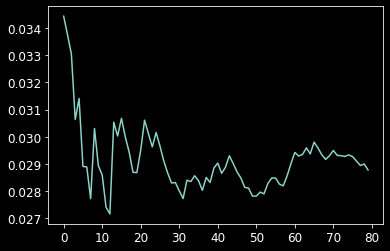

In [41]:
plt.plot([r_mse(preds[:i+1].mean(0), validY) for i in range(len(preds))]);

Out-of-Bag Error

In [42]:
r_mse(m.oob_prediction_, y)

0.027533

OOB error being about equal to higher than validation error means that our model is generalizing slightly better to the validation set than it is to the rest of training set.

OOB error being lower than our validation error means that something else is causing that error, in addition to normal generalization error. 

## Model Interpretation

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

As we will see, random forests are particularly well suited to answering these questions. Let's start with the first one!

### Tree Variance for Prediction Confidence

In [43]:
preds = np.stack([t.predict(validXs) for t in m.estimators_])

In [44]:
preds.shape

(80, 1137)

In [45]:
predsSD = preds.std(0)

In [46]:
predsSD[:10]

array([0.20590286, 0.22737057, 0.26002036, 0.23589663, 0.17412848, 0.24217413, 0.27355085, 0.19355985, 0.28678221, 0.30732414])

Some predictions are more confident than others based on whether most trees agree or not. This can be seen by varying magnitudes of standard deviation.

### Feature Importance

In [47]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [48]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
18,registered,0.693509
17,casual,0.249632
14,atemp,0.019139
13,temp,0.012204
15,humidity,0.007231
22,datetimeElapsed,0.006913
21,datetimeDayofyear,0.003247
2,workingday,0.001713
6,datetimeDayofweek,0.001555
19,datetimeWeek,0.001167


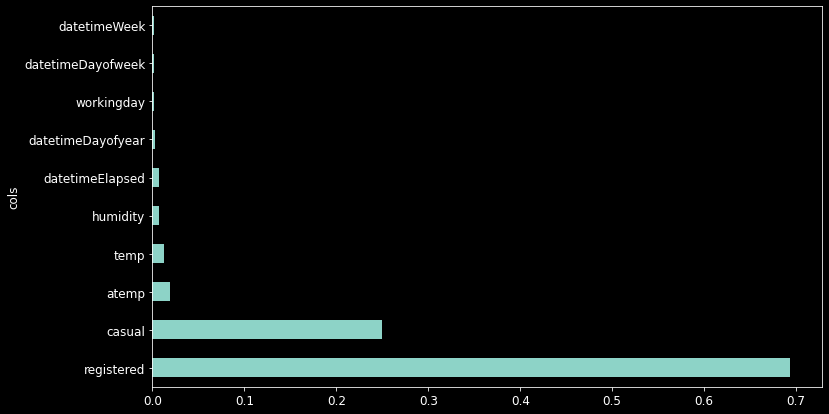

In [49]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:10]);

The number of `registered` and `casual` users make sense as the two biggest indicators because they each have a 1:1 correlation with the total number of rentals, count.

Let's look at the other categories without those two showing and dominating the graph,

<AxesSubplot:ylabel='cols'>

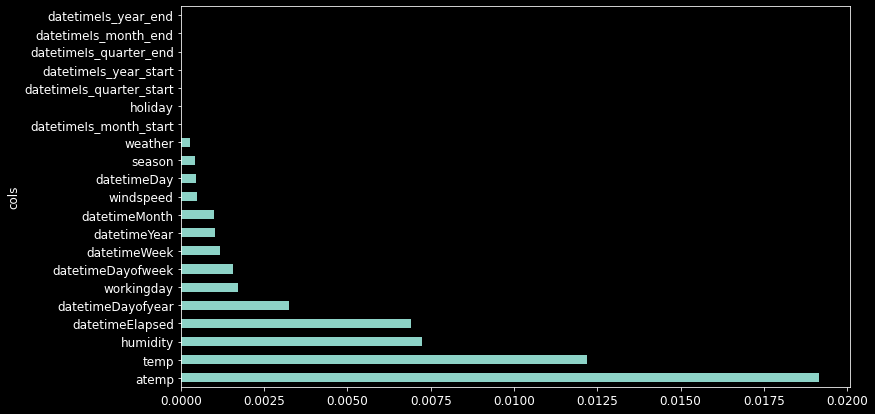

In [50]:
plot_fi(fi[2:30])

### Remove Low-Importance Variables

In [51]:
toKeep = fi[fi.imp>0.005].cols
toKeep

18         registered
17             casual
14              atemp
13               temp
15           humidity
22    datetimeElapsed
Name: cols, dtype: object

In [52]:
xsImp = xs[toKeep]
validXsImp = validXs[toKeep]

In [53]:
m = rf(xsImp, y)

In [54]:
m_rmse(m, xsImp, y), m_rmse(m, validXsImp, validY)

(0.019975, 0.020885)

Our accuracy is about the same, even a bit better, and now our model is simpler to train.

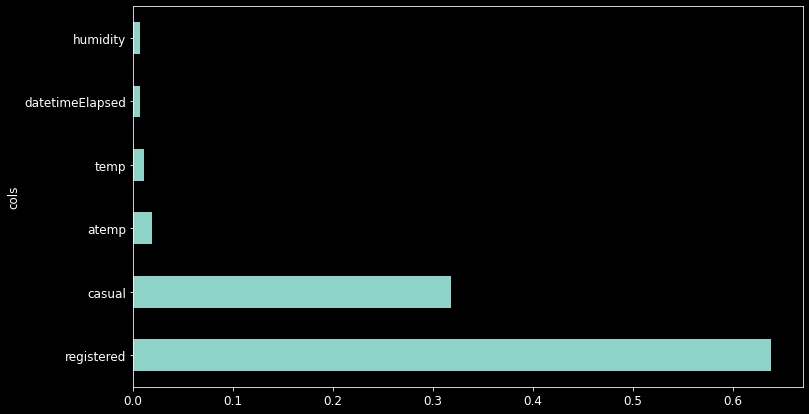

In [55]:
plot_fi(rf_feat_importance(m, xsImp));

### Remove Redundant Features

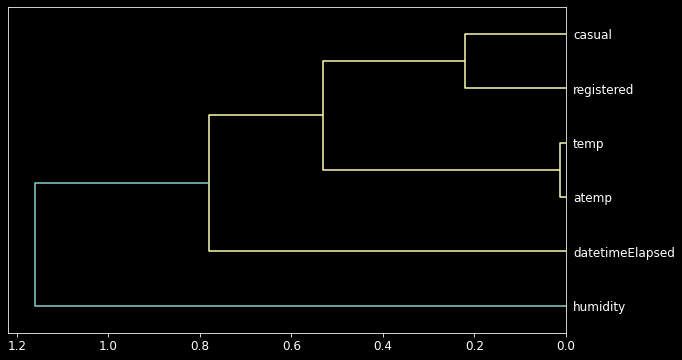

In [56]:
cluster_columns(xsImp)

We could try removing `temp` or `atemp`.

In [57]:
def get_oob(df):
    #m = RandomForestRegressor(n_estimators=80, min_samples_leaf=15, max_samples=None,
    #                          max_features=0.5, n_jobs=-1, oob_score=True)
    #m.fit(df, y)
    m = rf(df, y, max_samples=None)
    
    return m.oob_score_

In [58]:
get_oob(xsImp)

0.9992969878836799

In [59]:
{c:get_oob(xsImp.drop(c, axis=1)) for c in ('temp', 'atemp')}

{'temp': 0.9982400536162307, 'atemp': 0.9982363963948613}

1. The model's OOB score (higher is better) is higher when `atemp` is dropped. So, we can drop `atemp`, but that may be overkill.
2. Actually with log counts and RMSE the OOB scores are lower (worse) for each `temp` and `atemp` being removed. So keep them both in.

In [60]:
xsImp.columns

Index(['registered', 'casual', 'atemp', 'temp', 'humidity', 'datetimeElapsed'], dtype='object')

In [61]:
#toDrop = ['temp']
toDrop = []
get_oob(xsImp.drop(toDrop, axis=1))

0.9993108939481885

In [62]:
xsFinal = xsImp.drop(toDrop, axis=1)
validXsFinal = validXsImp.drop(toDrop, axis=1)
xsFinal.columns, validXsFinal.columns

(Index(['registered', 'casual', 'atemp', 'temp', 'humidity', 'datetimeElapsed'], dtype='object'),
 Index(['registered', 'casual', 'atemp', 'temp', 'humidity', 'datetimeElapsed'], dtype='object'))

In [63]:
m = rf(xsFinal, y)
m_rmse(m, xsFinal, y), m_rmse(m, validXsFinal, validY)

(0.021723, 0.024037)

1. The error is a bit better now after dropping nothing (it should be exactly the same)

2. Why does this error get so much smaller when I drop a column, but stays the same when I do nothing? 

    I'm worried that the error substantially changing here, even if it is for the better, is an indication that something is wrong with my model after dropping that category.

### Partial Dependence

In [64]:
to.classes['season']

['#na#', 1, 2, 3, 4]

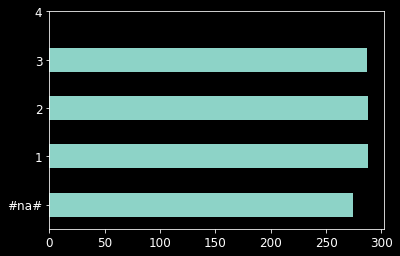

In [65]:
# all remaining variables are continuous so a bar plot doesn't really apply.
p = validXs['season'].value_counts(sort=False).plot.barh()
c = to.classes['season']
plt.yticks(ticks=range(len(c)), labels=c);

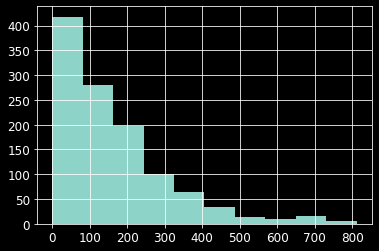

In [66]:
ax = validXsFinal['registered'].hist()

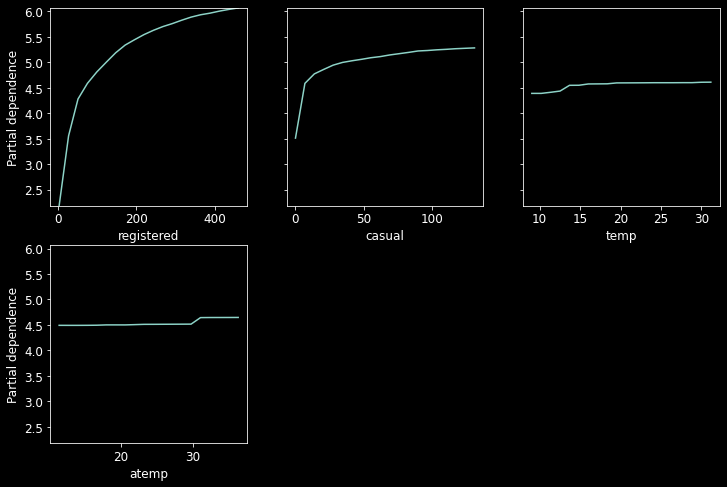

In [67]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12,8))
plot_partial_dependence(m, validXsFinal,
                        #['registered', 'casual', 'atemp'],
                        ['registered', 'casual', 'temp', 'atemp'],
                        grid_resolution=20, ax=ax);

This looks like a logarithmic dependence but the abscissa is log-scale so it's actually a linear dependence, which makes sense: total rentals would linearly scale with pre-registered rental appointments and casual rentals.

### Tree Interpreter

In [68]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [69]:
row = validXsFinal.iloc[:5]

In [70]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [71]:
prediction[0], bias[0], contributions[0].sum()

(array([1.13306148]), 4.546922229181827, -3.413860748913316)

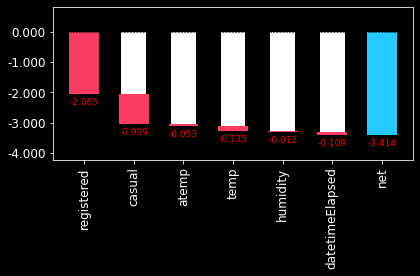

In [72]:
waterfall(validXsFinal.columns, contributions[0], threshold=0.001,
          rotation_value=90, formatting='{:,.3f}');

This information answers the question: "for predicting a particular row of data, what were the most important factors and how did they influence the prediction?"

## Extrapolation and Neural Networks

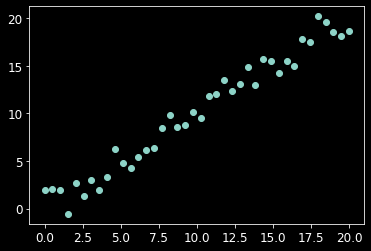

In [73]:
xLin = torch.linspace(0, 20, steps=40)
yLin = xLin + torch.randn_like(xLin)
plt.scatter(xLin, yLin);

In [74]:
xsLin = xLin[:,None]
xsLin.shape

torch.Size([40, 1])

In [75]:
mLin = RandomForestRegressor().fit(xsLin[:30], yLin[:30])

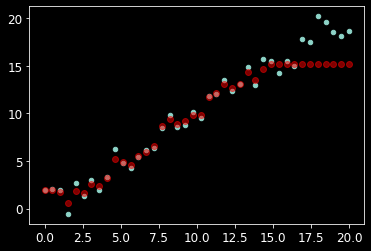

In [76]:
plt.scatter(xLin, yLin, 20)
plt.scatter(xLin, mLin.predict(xsLin), color='red', alpha=0.5);

### Finding Out-of-Domain Data

In [77]:
dfDom = pd.concat([xsFinal, validXsFinal])
isValid = np.array([0]*len(xsFinal) + [1]*len(validXsFinal))

m = rf(dfDom, isValid)
rf_feat_importance(m, dfDom)

,cols,imp
5,datetimeElapsed,0.657091
4,humidity,0.087696
1,casual,0.074755
0,registered,0.071327
2,atemp,0.055966
3,temp,0.053165


This shows that definitely one column differs between training and valid, `datetimeElapsed`, and maybe some others do too...

`datetimeElapsed` makes sense because the validation set days are at the end of the month, but the others don't make sense. Why would humidity be correlated to the validation set days? Which makes me think that a value $\le0.09$ is not significant, or conversely, that the validation data is actually quite different along all of these metrics from the training data.

In [78]:
m = rf(xsFinal, y)
print('orig', m_rmse(m, validXsFinal, validY))

categories = ('datetimeElapsed', 'humidity', 'temp', 'atemp', 'casual', 'registered')
#categories = ('datetimeElapsed', 'humidity', 'temp', 'casual', 'registered')
#categories = ('datetimeElapsed', 'humidity', 'atemp', 'casual', 'registered')

for c in categories:
    m = rf(xsFinal.drop(c, axis=1), y)
    print(c, m_rmse(m, validXsFinal.drop(c, axis=1), validY))

orig 0.021319
datetimeElapsed 0.031193
humidity 0.028906
temp 0.03214
atemp 0.032652
casual 0.070227
registered 0.189438


So, from the original RMSLE of ~0.0213 on the validation set we get more error if we drop anything more. The error increases much more if we drop `casual` or `registered` from our training.

In [113]:
dfTest

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeElapsed
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,3,20,3,20,False,False,False,False,False,False,1.295482e+09
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,20,3,20,False,False,False,False,False,False,1.295485e+09
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,20,3,20,False,False,False,False,False,False,1.295489e+09
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,20,3,20,False,False,False,False,False,False,1.295492e+09
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,20,3,20,False,False,False,False,False,False,1.295496e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,1,0,1,2,10.66,12.880,60,11.0014,2012,12,1,31,0,366,True,False,True,False,True,False,1.356980e+09
6489,1,0,1,2,10.66,12.880,60,11.0014,2012,12,1,31,0,366,True,False,True,False,True,False,1.356984e+09
6490,1,0,1,1,10.66,12.880,60,11.0014,2012,12,1,31,0,366,True,False,True,False,True,False,1.356988e+09
6491,1,0,1,1,10.66,13.635,56,8.9981,2012,12,1,31,0,366,True,False,True,False,True,False,1.356991e+09


In [112]:
dfTestFinal = dfTest[list(xsFinal.columns)]
dfTestFinal

KeyError: "['registered', 'casual'] not in index"

In [108]:
m.predict(dfTest)

ValueError: X has 21 features, but DecisionTreeRegressor is expecting 5 features as input.

### Using a Neural Network

In [79]:
dfNN = pd.read_csv(path/'train.csv', low_memory=False)
dfNN[depVar] = np.log(dfNN[depVar])
dfNN = add_datepart(dfNN, 'datetime')

In [80]:
dfNNTest = pd.read_csv(path/'test.csv', low_memory=False)
dfNNTest = add_datepart(dfNNTest, 'datetime')

In [81]:
' '.join(o for o in dfNN.columns if o.startswith('datetime'))

'datetimeYear datetimeMonth datetimeWeek datetimeDay datetimeDayofweek datetimeDayofyear datetimeIs_month_end datetimeIs_month_start datetimeIs_quarter_end datetimeIs_quarter_start datetimeIs_year_end datetimeIs_year_start datetimeElapsed'

In [82]:
xsFinal.columns

Index(['registered', 'casual', 'atemp', 'temp', 'humidity', 'datetimeElapsed'], dtype='object')

In [83]:
dfNNFinal = dfNN[list(xsFinal.columns) + [depVar]]
dfNNFinal

,registered,casual,atemp,temp,humidity,datetimeElapsed,count
0,13,3,14.395,9.84,81,1.293840e+09,2.772589
1,32,8,13.635,9.02,80,1.293844e+09,3.688879
2,27,5,13.635,9.02,80,1.293847e+09,3.465736
3,10,3,14.395,9.84,75,1.293851e+09,2.564949
4,1,0,14.395,9.84,75,1.293854e+09,0.000000
...,...,...,...,...,...,...,...
10881,329,7,19.695,15.58,50,1.355944e+09,5.817111
10882,231,10,17.425,14.76,57,1.355947e+09,5.484797
10883,164,4,15.910,13.94,61,1.355951e+09,5.123964
10884,117,12,17.425,13.94,61,1.355954e+09,4.859812


In [84]:
contNN,catNN = cont_cat_split(dfNNFinal, max_card=9000, dep_var=depVar)

In [85]:
contNN

['atemp', 'temp', 'datetimeElapsed']

In [86]:
catNN

['registered', 'casual', 'humidity']

In [87]:
dfNNFinal[catNN].nunique()

registered    731
casual        309
humidity       89
dtype: int64

In [88]:
dfNNFinal[contNN].nunique()

atemp                 60
temp                  49
datetimeElapsed    10886
dtype: int64

it seems to me that all of these variables are continuous in nature with the possible exception of humidity because it has a finite range 0-100. So shouldn't they all be continuous? Still humidity is a variable where each value is a continuous measurement of water vapor in the air so neighboring values should be realated to one-another, rather than completely different categories. 

In [89]:
for i in list(catNN):
    catNN.remove(i)
    contNN.append(i)
    print('catNN:', catNN)
    print('contNN:', contNN)

catNN: ['casual', 'humidity']
contNN: ['atemp', 'temp', 'datetimeElapsed', 'registered']
catNN: ['humidity']
contNN: ['atemp', 'temp', 'datetimeElapsed', 'registered', 'casual']
catNN: []
contNN: ['atemp', 'temp', 'datetimeElapsed', 'registered', 'casual', 'humidity']


In [90]:
dfNNFinal[catNN].nunique()

Series([], dtype: float64)

In [91]:
dfNNFinal[contNN].nunique()

atemp                 60
temp                  49
datetimeElapsed    10886
registered           731
casual               309
humidity              89
dtype: int64

In [92]:
xsFinal.columns

Index(['registered', 'casual', 'atemp', 'temp', 'humidity', 'datetimeElapsed'], dtype='object')

In [93]:
xsFinal.columns == validXsFinal.columns

array([ True,  True,  True,  True,  True,  True])

In [94]:
m2 = rf(xsFinal, y)
m_rmse(m2, xsFinal, y), m_rmse(m2, validXsFinal, validY)

(0.020493, 0.020468)

In [95]:
procsNN = [Categorify, FillMissing, Normalize]
toNN = TabularPandas(dfNNFinal, procs=procs, cat_names=catNN, cont_names=contNN,
                     y_names=depVar, splits=splits)

In [96]:
dls = toNN.dataloaders(1024)

In [97]:
y = toNN.train.y
y.min(), y.max()

(0.0, 6.8844867)

In [98]:
def loss_func(inp, targ):
    return 

In [99]:
F.cross_entropy??

In [100]:
learn = tabular_learner(dls, layers=[200,100], n_out=1,
                        y_range=(0,7), loss_func=F.mse_loss)

lrMin/10: 0.025118863582611083 lrSteep: 0.0014454397605732083


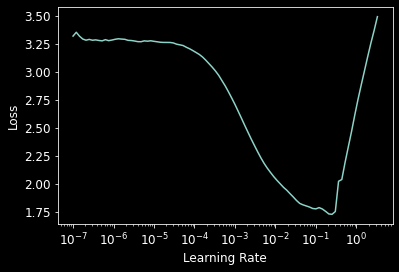

In [101]:
lrMin,lrSteep = learn.lr_find()
print('lrMin/10:', lrMin, 'lrSteep:', lrSteep)

In [102]:
learn.fit_one_cycle(10, lr_max=lrMin)

epoch,train_loss,valid_loss,time
0,1.200052,3.621444,00:00
1,0.946490,6.512983,00:00
2,0.871747,9.904158,00:00
3,0.737173,0.195934,00:00
4,0.595495,0.168895,00:00
5,0.485182,0.164377,00:00
6,0.404200,0.239965,00:00
7,0.345372,0.075004,00:00
8,0.295170,0.089851,00:00
9,0.254147,0.073181,00:00


In [103]:
preds,targs = learn.get_preds()
r_mse(preds, targs)

0.113356